## (E4)Sentimental_Analysis_of_Movie_Dataset_from_NAVER_InYu
### 1) 데이터 준비와 확인 & 2) 데이터로더 구성 
네이버 리뷰를 다운 받아서 다음과 같이 준비한다.
1. 중복 리뷰 삭제
2. Null 샘플 제거
3. 불용어 제거 -> 형태소 분석을 기준으로 토큰화 한다.  
    **위에서 저장된 x_train은 빈도가 높은 순으로 정수를 부여받는다.** 그래서 이중에서 가장 빈도 수가 많은 9996개의 단어로 리스트를만들어서 정수로 인코딩해준다. 앞에는 \<BOS>, \<PAD>, \<UNK>, \<UNUSED>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
4. 정수로 인코딩    
5. load_data

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.python.keras.callbacks import EarlyStopping

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 리뷰 삭제
    train_data = train_data.dropna(how = 'any') # Null 샘플 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    # 정수로 인코딩
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) # load_data

print(len(x_train))
print(len(x_test))

146182
49157


In [2]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [28]:
for i in range(20):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
.
영화
다
고
하
을
보
..
게
,
!
지
있
없
?
좋


In [3]:
# 데이터 확인해보기
train_data[:5] # label 0은 부정 평가, 1은 긍정 평가

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [29]:
type(train_data)

pandas.core.frame.DataFrame

### 3) 모델구성을 위한 데이터 분석 및 가공

문장 길이를 평준화해서 벡터의 길이는 조정한다.  
Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 하기 때문이다.  
긴 문장은 자르고 짧은 단어는 \<PAD>를 패딩해서 길이를 맞춰준다.

In [34]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
print(type(num_tokens))
num_tokens = np.array(num_tokens)
print(type(num_tokens))
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + round(2.5 * np.std(num_tokens))
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

<class 'list'>
<class 'numpy.ndarray'>
문장길이 평균 :  47.0
문장길이 최대 :  47
문장길이 표준편차 :  0.0
pad_sequences maxlen :  47
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


In [30]:
type(total_data_text), type(num_tokens)

list

In [36]:
type(x_train)

numpy.ndarray

RNN은 입력데이터가 순차적으로 처리되기 때문에 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리합니다.

In [37]:
# 위의 maxlen 값에 맞춰서 패딩
# post는 data 뒤에 패딩, pre는 data 앞에 패딩
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

In [38]:
type(x_train)

numpy.ndarray

In [40]:
x_train

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    2],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

### 4) 모델구성 및 validation set 구성
1. LSTM
2. CNN
3. GlobMP

총 3가지로 구성했습니다.

In [6]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

#LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, word_vector_dim))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))


#CNN
model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP = keras.Sequential()
model_GlobMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobMP.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_LSTM.summary()
model_CNN.summary()
model_GlobMP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           80000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               70144     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 150,273
Trainable params: 150,273
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          912       
____________________________

**영석님이 알려준** callbacks 내용을 추가해서 학습한다.  
검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [1]:
print('LSTM------------------------------------------------------------------------------------------------------')
# callbacks에 넣을 것들
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_LSTM = model_LSTM.fit(x_train, 
                                    y_train, 
                                    epochs=10, 
                                    callbacks=[es, mc], 
                                    batch_size=100, 
                                    validation_split=0.2)

LSTM------------------------------------------------------------------------------------------------------


NameError: name 'EarlyStopping' is not defined

In [8]:
loaded_model_LSTM = load_model('best_model_LSTM.h5')
results_LSTM = loaded_model_LSTM.evaluate(x_test, y_test)[1]
print(results_LSTM)

49157/49157 [==============================] - 9s 186us/sample - loss: 0.3125 - acc: 0.8653
0.8652888


In [9]:
print('CNN------------------------------------------------------------------------------------------------------')
# callbacks에 넣을 것들
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_CNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model_CNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history_model_CNN = model_CNN.fit(x_train, 
                                  y_train, 
                                  epochs=10, 
                                  callbacks=[es, mc], 
                                  batch_size=100, 
                                  validation_split=0.2)

CNN------------------------------------------------------------------------------------------------------
Train on 116945 samples, validate on 29237 samples
Epoch 1/10
115000/116945 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.7876
Epoch 00001: val_acc improved from -inf to 0.83627, saving model to best_model_CNN.h5
116945/116945 [==============================] - 4s 35us/sample - loss: 0.4454 - acc: 0.7884 - val_loss: 0.3734 - val_acc: 0.8363
Epoch 2/10
116200/116945 [============================>.] - ETA: 0s - loss: 0.3517 - acc: 0.8459
Epoch 00002: val_acc did not improve from 0.83627
116945/116945 [==============================] - 3s 28us/sample - loss: 0.3516 - acc: 0.8460 - val_loss: 0.3710 - val_acc: 0.8338
Epoch 3/10
115300/116945 [============================>.] - ETA: 0s - loss: 0.3297 - acc: 0.8564
Epoch 00003: val_acc improved from 0.83627 to 0.84981, saving model to best_model_CNN.h5
116945/116945 [==============================] - 3s 28us/sample - l

In [10]:
loaded_model_CNN = load_model('best_model_CNN.h5')
results_CNN = loaded_model_CNN.evaluate(x_test, y_test)[1]
print(results_CNN)

49157/49157 [==============================] - 2s 37us/sample - loss: 0.3483 - acc: 0.8473
0.8472649


In [11]:
print('GlobMP---------------------------------------------------------------------------------------------------')
model_GlobMP.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks_list = [
    # 검증 정확도(val_loss)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(monitor='val_loss', # 기본값은 monitor='val_loss'
                  patience=5),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(filepath='best_model_GlobMP.h5',
                    monitor='val_loss',
                    save_best_only=True)]

history_model_GlobMP = model_GlobMP.fit(x_train, 
                                        y_train, 
                                        epochs=30, 
                                        callbacks=callbacks_list, 
                                        batch_size=100, 
                                        validation_split=0.2)

GlobMP---------------------------------------------------------------------------------------------------
Train on 116945 samples, validate on 29237 samples
Epoch 1/30
116945/116945 [==============================] - 3s 25us/sample - loss: 0.5600 - acc: 0.7421 - val_loss: 0.4638 - val_acc: 0.8100
Epoch 2/30
116945/116945 [==============================] - 3s 22us/sample - loss: 0.4224 - acc: 0.8241 - val_loss: 0.4079 - val_acc: 0.8231
Epoch 3/30
116945/116945 [==============================] - 3s 22us/sample - loss: 0.3835 - acc: 0.8369 - val_loss: 0.3911 - val_acc: 0.8300
Epoch 4/30
116945/116945 [==============================] - 3s 22us/sample - loss: 0.3672 - acc: 0.8429 - val_loss: 0.3850 - val_acc: 0.8324
Epoch 5/30
116945/116945 [==============================] - 3s 22us/sample - loss: 0.3588 - acc: 0.8468 - val_loss: 0.3803 - val_acc: 0.8339
Epoch 6/30
116945/116945 [==============================] - 3s 22us/sample - loss: 0.3533 - acc: 0.8492 - val_loss: 0.3784 - val_acc: 0.83

In [12]:
loaded_model_GlobMP = load_model('best_model_GlobMP.h5')
results_GlobMP = loaded_model_GlobMP.evaluate(x_test, y_test)[1]
print(results_GlobMP)

49157/49157 [==============================] - 2s 31us/sample - loss: 0.3800 - acc: 0.8346
0.83461154


In [13]:
print('LSTM-----------------------------------------')
print(results_LSTM)
print('CNN-----------------------------------------')
print(results_CNN)
print('GlobMP-----------------------------------------')
print(results_GlobMP)

LSTM-----------------------------------------
0.8652888
CNN-----------------------------------------
0.8472649
GlobMP-----------------------------------------
0.83461154


### 6) Loss, Accuracy 그래프 시각화
4개의 모델에 대한 history 가져오기  
.key()는 epoch을 기준으로 그래프를 그려볼 수 있는 항목

In [14]:
history_dict_LSTM = history_model_LSTM.history
history_dict_CNN = history_model_CNN.history
history_dict_GlobMP = history_model_GlobMP.history
print(history_dict_GlobMP.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


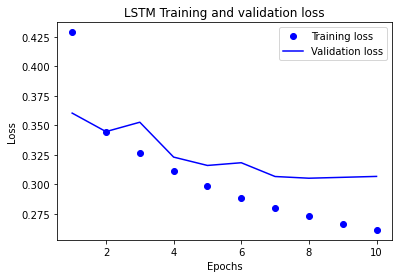

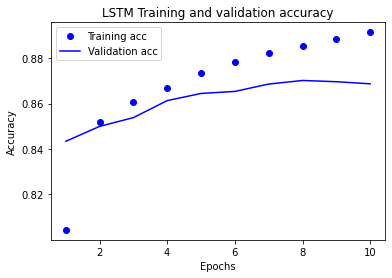

In [15]:
import matplotlib.pyplot as plt
# LSTM
acc = history_dict_LSTM['acc']
val_acc = history_dict_LSTM['val_acc']
loss = history_dict_LSTM['loss']
val_loss = history_dict_LSTM['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

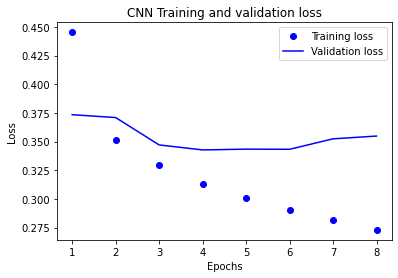

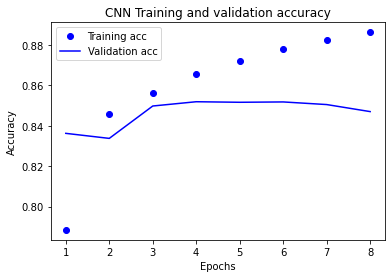

In [16]:
import matplotlib.pyplot as plt
# CNN
acc = history_dict_CNN['acc']
val_acc = history_dict_CNN['val_acc']
loss = history_dict_CNN['loss']
val_loss = history_dict_CNN['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

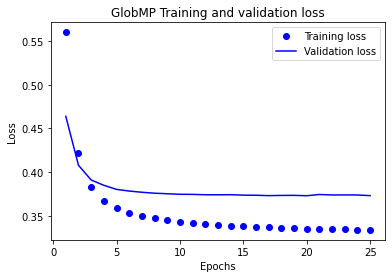

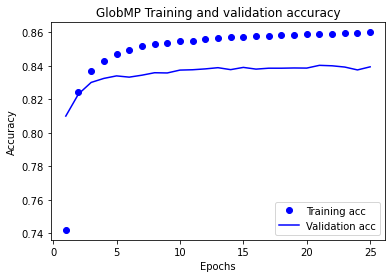

In [17]:
import matplotlib.pyplot as plt
# GlobMP
acc = history_dict_GlobMP['acc']
val_acc = history_dict_GlobMP['val_acc']
loss = history_dict_GlobMP['loss']
val_loss = history_dict_GlobMP['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobMP Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobMP Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

LSTM에서는 epochs=9에서 loss가 가장 낮고,  
CNN에서는 5번째에가 가장 낮고,  
globalmaxpooling 레이어에서는 5번째 이후로는 loss가 거의 비슷하지만 13번째가 제일 낮았다.

### 7) 학습된 Embedding 레이어 분석
정확도가 가장 낮았던 **GlobMP**의 embedding_layer에 대입해서  
gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용해보자.  
이 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 주어진 단어와 벡터가 비슷한 단어와의 유사도로 확인할 수 있는 방법이 있다. 이 방벙으로 GlobMP로 학습이 어느 정도로 되었는지 확인해보자.

In [18]:
# GLobMP
embedding_layer = model_GlobMP.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 8)


In [19]:
import os

# 학습한 GlobMP Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_GlobMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GlobMP.txt'
f = open(word2vec_file_path_GlobMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_GlobMP.get_weights()[0] # 이게 원-핫일 것이다.
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_GlobMP = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GlobMP, binary=False)
vector_GlobMP = word_vectors_GlobMP['팝콘']
vector_GlobMP

array([ 0.03269733,  0.2265162 , -0.2555912 , -0.368357  ,  0.51224774,
        1.2564783 , -0.25130278,  0.4335137 ], dtype=float32)

In [21]:
word_vectors_GlobMP.similar_by_word('팝콘')

[('자질', 0.9704517722129822),
 ('호구', 0.9694958925247192),
 ('발악', 0.9647912979125977),
 ('지루', 0.9623459577560425),
 ('치중', 0.9568285942077637),
 ('좀비', 0.952324390411377),
 ('산', 0.9501489400863647),
 ('시망', 0.9471719861030579),
 ('잠들', 0.9437377452850342),
 ('몰락', 0.9406015872955322)]

벡터만 보면 유사도가 높아보이지만 실제 단어끼리의 유사도가 많이 떨어지는 것을 확인할 수 있었다.  
10000개의 data는 아주 작은 양이기 때문이다.  
그래서 자체학습이 아닌 사전학습된 한국어 Word2Vec 임베딩을 활용하여 다른 모델의 성능을 개선해보자.

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
사전 학습 되어있는 ko.bin의 embedding_layer를 정확도가 가장 높았던 LSTM과 가장 낮았던 GlobMP 모델에 대입해서  
전에 모델에 비해 성능이 발전했는지 확인하기.

In [22]:
from gensim.models import KeyedVectors
import os
import gensim

ko_model = gensim.models.Word2Vec.load('./sentiment_classification/ko.bin')
word2vec = ko_model
vector = ko_model['강아지']
len(vector)

FileNotFoundError: [Errno 2] No such file or directory: './sentiment_classification/ko.bin'

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant
# model 설계

#LSTM
model_LSTM2 = Sequential()
model_LSTM2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM2.add(LSTM(128))
model_LSTM2.add(Dense(1, activation='sigmoid'))


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP2 = keras.Sequential()
model_GlobMP2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model_GlobMP2.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_LSTM2.summary()
model_GlobMP2.summary()

In [ ]:
print('LSTM------------------------------------------------------------------------------------------------------')
model_LSTM2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks_list = [
    # 검증 정확도(val_loss)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(monitor='val_loss', # 기본값은 monitor='val_loss'
                  patience=5),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(filepath='my_model_LSTM2.h5',
                    monitor='val_loss',
                    save_best_only=True)]

history_model_LSTM2 = model_LSTM2.fit(x_train, 
                                        y_train, 
                                        epochs=10, 
                                        callbacks=callbacks_list, 
                                        batch_size=100, 
                                        validation_split=0.2)

In [ ]:
loaded_model_LSTM2 = load_model('my_model_LSTM2.h5')
results_LSTM2 = loaded_model_LSTM2.evaluate(x_test, y_test)[1]
print(results_LSTM2)

In [ ]:
print('Before :',results_LSTM)
print('--------------------------------------------')
print('After :',results_LSTM2)

In [ ]:
print('GlobMP---------------------------------------------------------------------------------------------------')
model_GlobMP2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks_list = [
    # 검증 정확도(val_loss)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(monitor='val_loss', # 기본값은 monitor='val_loss'
                  patience=5),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(filepath='my_model_GlobMP2.h5',
                    monitor='val_loss',
                    save_best_only=True)]

history_model_GlobMP2 = model_GlobMP2.fit(x_train, 
                                        y_train, 
                                        epochs=30, 
                                        callbacks=callbacks_list, 
                                        batch_size=100, 
                                        validation_split=0.2)

In [ ]:
loaded_model_GlobMP2 = load_model('my_model_GlobMP2.h5')
results_GlobMP2 = loaded_model_GlobMP2.evaluate(x_test, y_test)[1]
print(results_GlobMP2)

In [ ]:
print('Before :',results_GlobMP)
print('--------------------------------------------')
print('After :',results_GlobMP2)

## 루브릭 평가
### 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
1. LSTM
2. CNN
3. GlobMP  

총 3가지의 모델로 평가해보았다. 

LSTM이 86.5% acc로 가장 높게 나왔고, GlobalMaxPooling 레이어 하나만 쓴 모델이 83.4%로 가장 낮은 acc으로 나왔다.  


### 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
gensim의 유사단어 찾기를 활용하여 자체학습한 GlobalMaxPooling 임베딩에서 '팝콘'을 찾아봤지만, 유사하지 않은 단어가 많이 나왔다.  
그래서 사전학습된 한국어 Word2Vec을 추가해서 모델을 다시 돌려보자.
    

### 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
정확도가 가장 높은 LSTM과 가장 낮은 GlobalMaxPooling에 embeddin 레이어를 추가하였다.  
LSTM은 약 0.2%, GlobalMaxPooling은 약 0.7%정도 성능이 향상된 것을 확인할 수 있다. 사전 학습된  Word2Vec을 활요해서 이 정도면, 자체 학습  Word2Vec은 더 조금 올랐을 것이라고 예상할 수 있다.

***

## 회고
정말 많은 오류때문에 고생했던 노드이다. 여러 모델을 돌려서 85% 정확도를 찾아내는 것도 난이도가 높았다. 하지만 Word2Vec은 노드에 설명이 많이 부족하고, 문맥도 이해가 가지 않아서 밤늦게까지 조원들과 함께 토론을 했다. 그래도 조원들 뿐만 아니라 영석 퍼실님까지 끝까지 도와주셔서 이렇게 오류럽고 성능이 잘 오른 결과를 낼 수 있었다. 힘들었지만 재미도 있었다.  
  
## 더 탐구
- vocab size를 더 줄이거나 늘릴때 accuracy는?
- 토큰화란?
- 토큰화와 불용어 제거의 관계
- 노드에서는 pre와 post 패딩이 10% 차이가 난다고 했는데, 실제로 해보았을 때 그렇지 않았다. 그 이유는?
- relu는 무엇인가
- layer의 이해 부족